# **Course Rating Prediction using Neural Networks**


Intro: I'm building myself a course recommender for Coursera courses this is also an exploration and instructions on how to build a recommendation model using Tensorflows Keras Models. 
>
In this notebook I will explore Keras RecommenderNet model, a superclass of tge Sequential class from initialization to training and evaluation. Documentation found here: https://www.tensorflow.org/api_docs/python/tf/keras/Model
>
To run this notebook you must use tensorflow 2.7 and Python 3.8 in order to run properly.

# Continuation from previous notebook

In the previous notebooks I crafted several types of user and item feature vectors. For example, given a user `i`, we build its profile feature vector and course rating feature vector, and given an item `j`, we create its genre vector and user enrollment vectors.


With these explicit features vectors, I will perform machine learning tasks such as calculating the similarities among users or items, finding nearest neighbors, and using dot-product to estimate a rating value. 

The main advantage of using these explicit features is they are highly interpretable and yield very good performance. The main disadvantage is the time and processing needed to build and store them.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/explicit_user_item_features.png)


To predict a rating without building explicit feature vectors the Non-negative Matrix Factorization can decomposes the user-item interaction matrix into user matrix and item matrix, which contain the latent features of users and items. Using a dot-product I can get an estimated rating.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/nmf.png)


In addition to NMF, neural networks can also be used to extract the latent user and item features. When training neural networks, it gradually captures and stores the features within its hidden layers as weight matrices and can be extracted to represent the original data. 

In this notebook, I will be training neural networks to predict course ratings while simultaneously extracting users' and items' latent features. 

## Objectives


* Use `tensorflow` to train neural networks to extract the user and item latent features from the hidden's layers  
* Predict course ratings with `Keras` model and train a neural networks for later use. 

----


## Prepare and setup lab environment


Py 3.8 and tensorflow 2.7 required.


In [1]:
!pip install tensorflow==2.7.0

Import required libraries:


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%pip install protobuf==3.20.0

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.24.4 which is incompatible.


  Using cached protobuf-3.20.0-cp38-cp38-win_amd64.whl.metadata (699 bytes)
Using cached protobuf-3.20.0-cp38-cp38-win_amd64.whl (904 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
Note: you may need to restart the kernel to use updated packages.


C:\Users\willl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\framework\dtypes.py:585: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
# also set a random state
rs = 123

### Load and processing rating dataset


In [5]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


This is the same rating dataset we have been using in previous lab, which contains the three main columns: `user`, `item`, and `rating`. 


Next, let's figure out how many unique users and items, their total numbers will determine the sizes of one-hot encoding vectors.


In [6]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


It means each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.


The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction (such as the probability of completing a course). 

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/embedding_feature_vector.png)


The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


#### Implementing the recommender neural network using tensorflow 


This network architecture could be defined and implemented as a sub-class inheriting the `tensorflow.keras.Model` super class, let's call it `RecommenderNet()`.


In [7]:
class RecommenderNet(keras.Model):

    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")

        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")

    def call(self, inputs):
        """
           method to be called during model fitting

           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

### Train and evaluate the RecommenderNet()


Now it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.


In [8]:
def process_dataset(raw_data):

    encoded_data = raw_data.copy()

    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}

    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [9]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [10]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


Then we can split the encoded dataset into training and testing datasets.


In [11]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

If we take a look at the training input data, it is simply just a list of user indices and item indices, which is a dense format of one-hot encoding vectors.


In [13]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973], dtype=int64)

In [14]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17], dtype=int64)

and training output labels are a list of 0s and 1s indicating if the user has completed a course or not.


In [15]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

Then we can choose a small embedding vector size to be 16 and create a `RecommenderNet()` model to be trained


In [16]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

Actual training of the RecommenderNet() model.

Epoch 1/10
2917/2917 [==============================] - 6s 2ms/step - loss: 0.0032 - root_mean_squared_error: 0.0507 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1029
Epoch 2/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0566 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1021
Epoch 3/10
2917/2917 [==============================] - 7s 2ms/step - loss: 0.0043 - root_mean_squared_error: 0.0563 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1028
Epoch 4/10
2917/2917 [==============================] - 7s 2ms/step - loss: 0.0045 - root_mean_squared_error: 0.0569 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1029
Epoch 5/10
2917/2917 [==============================] - 5s 2ms/step - loss: 0.0048 - root_mean_squared_error: 0.0578 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1020
Epoch 6/10
2917/2917 [==============================] - 6s 2ms/step - loss: 0.0050 - root_mean_squared_error: 0.0589 - val_loss: 0

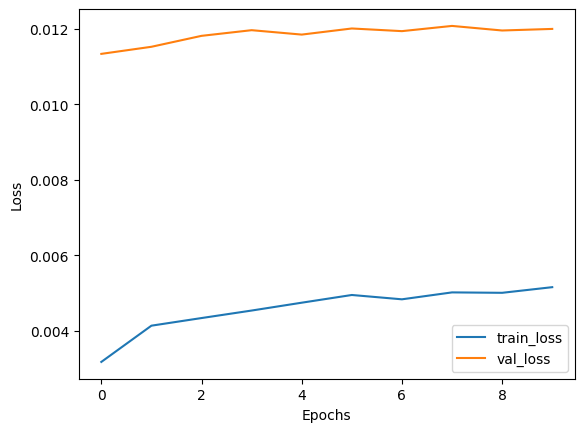

: 

In [ ]:
# Train the ReccomenderNet model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

# Evaluate the model
test_loss, test_rmse = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}")

# Plot the training history
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
# Save the model
model.save("recommender_net", save_format="tf")

INFO:tensorflow:Assets written to: recommender_net\assets


Evaluate the trained model


365/365 [==============================] - 0s 811us/step - loss: 0.0164 - root_mean_squared_error: 0.1211
Test Loss: 0.016385899856686592, Test RMSE: 0.12111137807369232


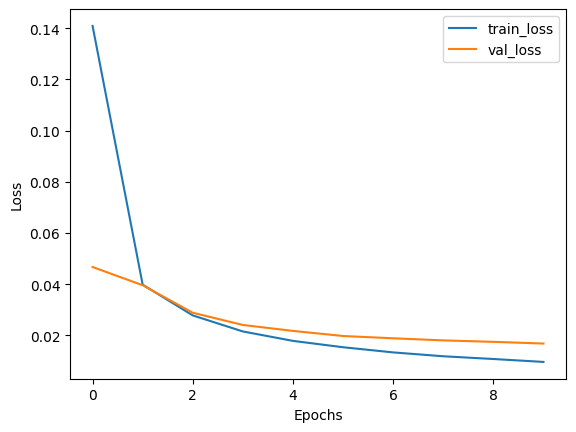

In [25]:
### WRITE YOUR CODE HERE

# call model.evaluate() to evaluate the model
test_loss, test_rmse = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}")

# Plot the training history
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


### Extract the user and item embedding vectors as latent feature vectors


Now, we have trained the `RecommenderNet()` model and it can predict the ratings with relatively small RMSE. 

If we print the trained model then we can see its layers and their parameters/weights.


In [26]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embed  multiple                 542416    
 ding)                                                           
                                                                 
 user_bias (Embedding)       multiple                  33901     
                                                                 
 item_embedding_layer (Embed  multiple                 2016      
 ding)                                                           
                                                                 
 item_bias (Embedding)       multiple                  126       
                                                                 
Total params: 578,459
Trainable params: 578,459
Non-trainable params: 0
_________________________________________________________________


In the `RecommenderNet`, the `user_embedding_layer` and `item_embedding_layer` layers contain the trained weights. Essentially, they are the latent user and item features learned by `RecommenderNet` and will be used to predict the interaction. As such, while training the neural network to predict rating, the embedding layers are simultaneously trained to extract the embedding user and item features.


We get the actual weights using `model.get_layer().get_weights()` methods

In [27]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [28]:
user_latent_features[0]

array([-0.07971399,  0.02190097,  0.06299648,  0.06338354,  0.08058902,
        0.06368961,  0.10224759,  0.0625804 ,  0.1049967 ,  0.10885881,
       -0.041633  , -0.00229856, -0.02376937, -0.03623926, -0.04750477,
       -0.08220511], dtype=float32)

In [29]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [30]:
item_latent_features[0]

array([ 0.00895729, -0.02607382,  0.02189192, -0.0348515 , -0.018617  ,
        0.03212859, -0.01901862,  0.01087425, -0.03521964,  0.01135781,
        0.00939059, -0.02728592, -0.00720162,  0.00377875,  0.01657311,
       -0.01988745], dtype=float32)

Now, each user of the total 33901 users has been transformed into a 16 x 1 latent feature vector and each item of the total 126 has been transformed into a 16 x 1 latent feature vector.


### ToDo: Tune model through iterations


This `RecommenderNet()` is a very basic neural network, this section will be used to try and improve the prediction performance. General notes:
- Hyperparameter tuning, such as the embedding layer dimensions
- Add more hidden layers
- Try different activation functions such as `ReLu`


In [4]:
# Steps:
# Update RecommenderNet() class to include the user and item bias
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")

        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")

    def call(self, inputs):
        """
           method to be called during model fitting

           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)


NameError: name 'keras' is not defined

In [ ]:
# compile and fit the updated model
model = RecommenderNet(num_users, num_items, embedding_size)

# Train the ReccomenderNet model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

# Evaluate the model
test_loss, test_rmse = model.evaluate(x_test, y_test, batch_size=64)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}")

# Plot the training history
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save("recommender_net", save_format="tf")

### Summary


This notebook I used keras model in tensorflow to create the feature weights for the model using course data and course rating data. We can extract or embed users and items data into latent feature spaces and further predict the interaction between a user and an item/course with the latent feature vectors. 

### Final Thought
The training model has too low of performance for my liking and Not be tuned further has there are likely much better options to explore. This will serve as a reference for future prediction based models. With a predefined and trained neural network.

William Ruffu
